## How to work with Climate Adaptation Digital Twin data on Earth Data Hub: standard resolution fields on a single level or surface

***
This notebook will provide you guidance on how to access and use the [`https://data.earthdatahub.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr`](https://earthdatahub.com/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-standard-sfc) datset on [Earth Data Hub](https://earthdatahub.com).

***
### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***

Our first goal is to plot the mean 2 metre temperature in January 2025 over Central Europe.

Our second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2028 reference period.

### Data access and preview
***

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [15]:
import xarray as xr

ds = xr.open_dataset(
    "https://data.earthdatahub.com/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

ClientResponseError: 401, message='Unauthorized', url=URL('https://data.earthdatahub.com/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr/.zmetadata')

### Working with EDH data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of an EDH workflow looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

### Average 2 metre temperature in Germany, January 2025

#### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [4]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 84936, latitude: 23, longitude: 31)> Size: 242MB
dask.array<getitem, shape=(84936, 23, 31), dtype=float32, chunksize=(576, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 679kB 2020-01-01 ... 2029-09-08T23:00:00
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select January 2025. This is again a lazy operation:

In [5]:
t2m_germany_area_january_2025 = t2m_germany_area.sel(time="2025-01")
t2m_germany_area_january_2025

<xarray.DataArray 't2m' (time: 744, latitude: 23, longitude: 31)> Size: 2MB
dask.array<getitem, shape=(744, 23, 31), dtype=float32, chunksize=(504, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:00:00
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [6]:
%%time

t2m_germany_area_january_2025 = t2m_germany_area_january_2025.compute()

CPU times: user 512 ms, sys: 141 ms, total: 653 ms
Wall time: 28.8 s


The data was very small, this didn't take long.

#### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2025 monthly mean:

In [7]:
t2m_germany_area_january_2025_monthly_mean = t2m_germany_area_january_2025.mean(dim="time")
t2m_germany_area_january_2025_monthly_mean

<xarray.DataArray 't2m' (latitude: 23, longitude: 31)> Size: 3kB
array([[ -0.77667993,  -1.1711727 ,  -1.1711727 ,  -4.465508  ,
         -4.465508  ,  -2.4917378 ,  -3.9073758 ,  -3.28876   ,
         -4.962482  ,  -4.962482  ,  -7.304508  ,  -7.304508  ,
         -7.137338  ,  -7.137338  ,  -8.358436  ,  -8.358436  ,
         -7.2853556 ,  -9.674631  ,  -9.674631  , -11.999253  ,
        -11.999253  ,  -8.982602  ,  -8.982602  ,  -9.22958   ,
         -9.22958   ,  -7.681051  ,  -5.615873  ,  -5.615873  ,
         -4.1487985 ,  -4.1487985 ,  -2.4964435 ],
       [ -1.340862  ,  -1.4100826 ,  -1.4100826 ,  -2.4917378 ,
         -2.4917378 ,  -2.4917378 ,  -3.28876   ,  -3.28876   ,
         -3.7985048 ,  -3.7985048 ,  -4.1506557 ,  -4.1506557 ,
         -4.976595  ,  -4.976595  ,  -4.976595  ,  -7.2853556 ,
         -7.2853556 ,  -8.500911  ,  -8.500911  ,  -7.1247506 ,
         -7.1247506 ,  -6.749936  ,  -6.749936  ,  -6.749936  ,
         -7.681051  ,  -7.681051  ,  -9.347692  ,  -9.347692  ,
         -6.3846855 ,  -6.3846855 ,  -3.8685608 ],
       [ -2.3059182 ,  -1.4688865 ,  -1.4688865 ,  -1.4688865 ,
         -2.8237288 ,  -2.8237288 ,  -1.5713733 ,  -1.5713733 ,
         -3.8337862 ,  -3.8337862 ,  -4.1506557 ,  -2.3459044 ,
         -2.3459044 ,  -4.429888  ,  -4.429888  ,  -5.6230955 ,
...
         -1.7891171 ,  -3.5722117 ,  -3.5722117 ,  -1.5747353 ,
         -4.1523333 ,  -4.1523333 ,  -3.1405969 ,  -4.6439257 ,
         -2.5149264 ,  -3.3664033 ,  -3.3664033 ,  -1.7041055 ,
         -5.7645526 ,  -5.7645526 ,  -2.1426163 ],
       [  1.8022643 ,   1.7901677 ,   1.3150352 ,   1.3150352 ,
          0.6749184 ,   0.6749184 ,   0.30395657,  -0.33850196,
         -0.33850196,  -0.95678335,  -2.4450328 ,  -2.4450328 ,
         -2.7225869 ,  -2.7225869 ,  -2.0975842 ,  -1.7891171 ,
         -1.7891171 ,  -1.6594107 ,  -1.5747353 ,  -1.5747353 ,
         -3.1405969 ,  -3.1405969 ,  -1.0743922 ,  -2.5149264 ,
         -2.5149264 ,  -0.9897138 ,  -1.7041055 ,  -1.7041055 ,
         -2.1426163 ,  -2.1426163 ,  -1.0777519 ],
       [  1.7901677 ,   1.6456795 ,   1.1897004 ,   1.1897004 ,
          0.30395657,   0.30395657,   0.30395657,  -0.95678335,
         -0.95678335,  -1.263909  ,  -2.7622368 ,  -2.7622368 ,
         -2.0975842 ,  -2.0975842 ,  -2.0975842 ,  -1.6594107 ,
         -1.6594107 ,  -1.6594107 ,  -2.5045083 ,  -2.5045083 ,
         -3.5122294 ,  -1.0743922 ,  -1.0743922 ,  -0.9897138 ,
         -0.9897138 ,  -0.9897138 ,  -0.8220379 ,  -0.8220379 ,
         -3.3220477 ,  -1.0777519 ,  -1.0777519 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0

#### 3. Visualization
Finally, we can plot the january 2025 monthly mean on a map:

In [8]:
import display
import matplotlib.pyplot as plt

<GeoAxes: title={'center': 'Mean Surface Temperature, Jan 2025'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/nicola/opt/miniconda3/envs/edh/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


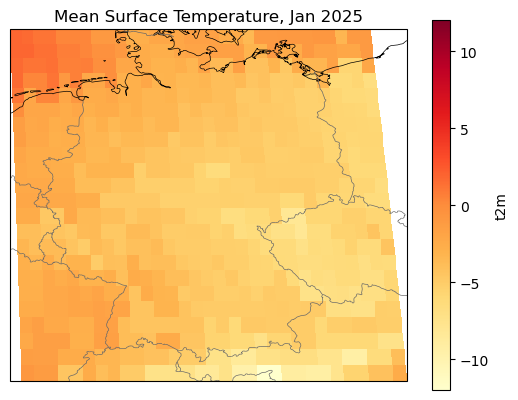

In [9]:
display.map(t2m_germany_area_january_2025_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Jan 2025")

## 2 metre temperature climatology in Berlin, 2020-2028 

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin for the reference period 2020-2028.

We first select the closet data to Berlin:

In [10]:
%%time

t2m_Berlin_2020_2028 = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest").sel(time=slice("2020", "2028"))
t2m_Berlin_2020_2028

CPU times: user 23.1 ms, sys: 15.9 ms, total: 39 ms
Wall time: 6.34 ms


<xarray.DataArray 't2m' (time: 78912)> Size: 316kB
dask.array<getitem, shape=(78912,), dtype=float32, chunksize=(576,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 52.66
    longitude  float64 8B 13.36
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 631kB 2020-01-01 ... 2028-12-31T23:00:00
Attributes:
    units:    C

This is already small enought to be computed:

In [11]:
%%time

t2m_Berlin_2020_2028 = t2m_Berlin_2020_2028.compute()

CPU times: user 19.9 s, sys: 4.18 s, total: 24 s
Wall time: 5min 48s


Now that the data is loaded in memory we can easily compute the climatology:

In [12]:
t2m_Berlin_climatology_mean = t2m_Berlin_2020_2028.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin_2020_2028.groupby("time.month").std(dim="time")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We can finally plot the climatology in Berlin for the 2020-2028 refrence period

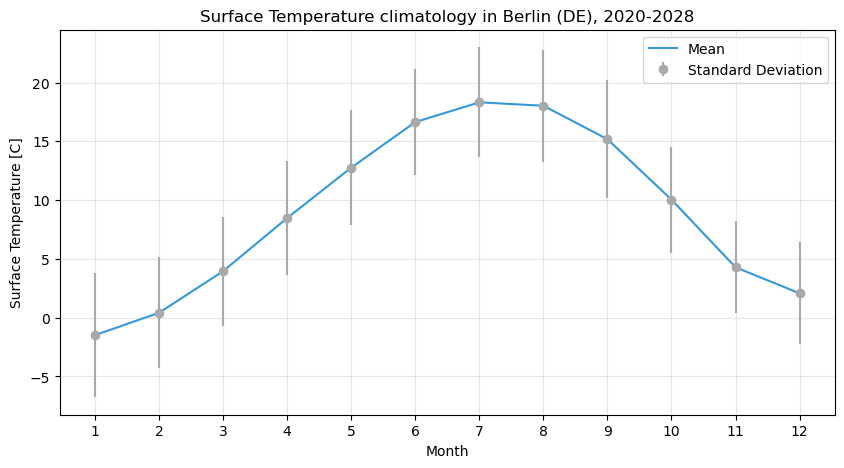

In [13]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2028")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()